In [8]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Activation,Conv2D,Flatten,Dense,MaxPooling2D
from keras.models import Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import tensorflow as tf
import keras
from itertools import cycle


In [2]:
x_train=np.load('dataset/x_train.npy').astype(np.float32)
y_train=np.load('dataset/y_train.npy').astype(np.float32)
x_val=np.load('dataset/x_val.npy').astype(np.float32)
y_val=np.load('dataset/y_val.npy').astype(np.float32)

print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


In [3]:
CLASS_LABELS=['0','1']

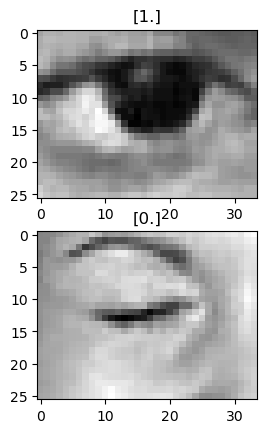

In [4]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [6]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [9]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
with tf.device("/device:GPU:0"):
    hist=model.fit(train_generator, epochs=100, validation_data=val_generator,
              callbacks=[ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
            ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
        ]
    )

Epoch 1/100
80/81 [============================>.] - ETA: 0s - loss: 0.5138 - acc: 0.7616
Epoch 1: val_acc improved from -inf to 0.86806, saving model to models\2022_11_13_23_07_42.h5
81/81 [==============================] - 7s 15ms/step - loss: 0.5125 - acc: 0.7626 - val_loss: 0.2968 - val_acc: 0.8681 - lr: 0.0010
Epoch 2/100
77/81 [===========================>..] - ETA: 0s - loss: 0.2760 - acc: 0.8906
Epoch 2: val_acc improved from 0.86806 to 0.91319, saving model to models\2022_11_13_23_07_42.h5
81/81 [==============================] - 1s 9ms/step - loss: 0.2743 - acc: 0.8917 - val_loss: 0.2159 - val_acc: 0.9132 - lr: 0.0010
Epoch 3/100
78/81 [===========================>..] - ETA: 0s - loss: 0.1954 - acc: 0.9269
Epoch 3: val_acc improved from 0.91319 to 0.95139, saving model to models\2022_11_13_23_07_42.h5
81/81 [==============================] - 1s 9ms/step - loss: 0.1935 - acc: 0.9281 - val_loss: 0.1163 - val_acc: 0.9514 - lr: 0.0010
Epoch 4/100
77/81 [==========================

# Evaluating model

In [10]:
model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))

9/9 [==============================] - 0s 16ms/step
test acc: 0.9895833333333334


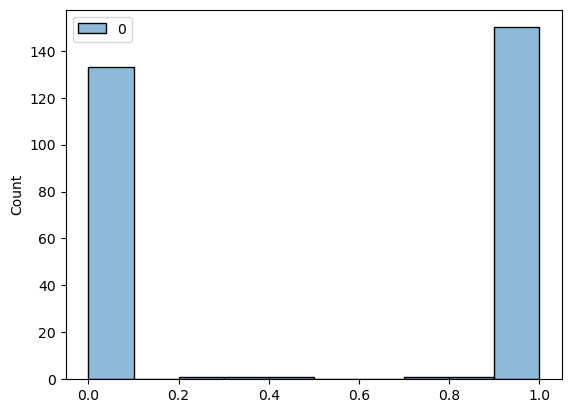

In [11]:
ax = sns.histplot(y_pred, kde=False)

# Visualizing Train,Test--->Accuracy,Loss

<Figure size 640x480 with 0 Axes>

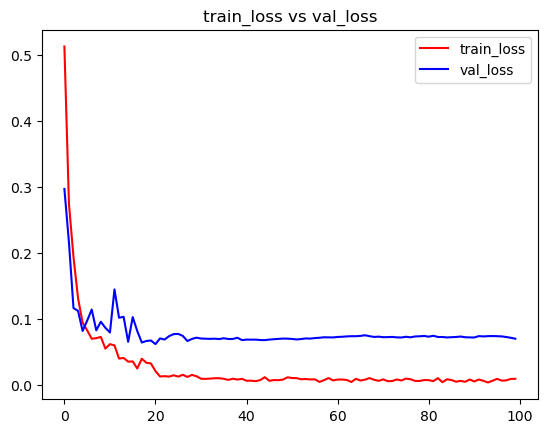

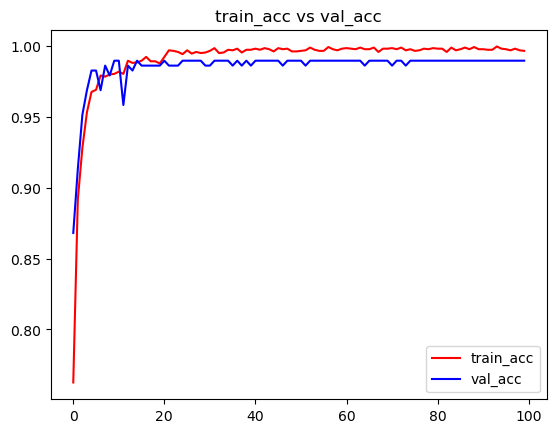

<Figure size 640x480 with 0 Axes>

In [12]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

# Confusion Matrix

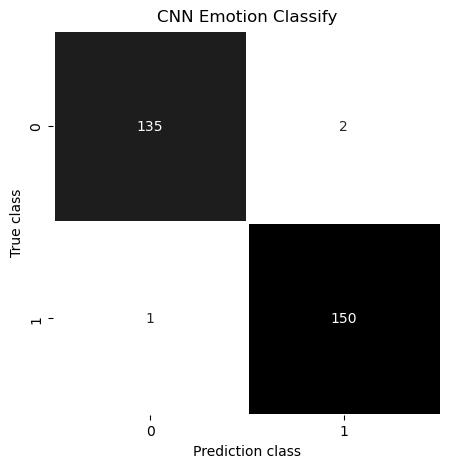

In [13]:
cm = confusion_matrix(y_val, y_pred_logical)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

# Classification Report

In [14]:
print(classification_report(y_val, y_pred_logical))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       137
         1.0       0.99      0.99      0.99       151

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



# ROC Curve

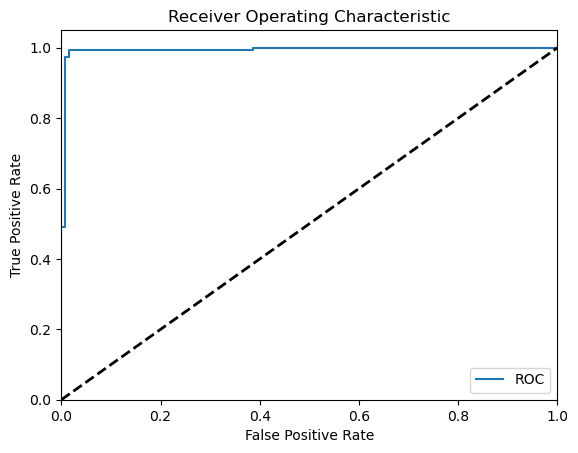

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _=roc_curve(y_val, y_pred)
plt.plot(fpr, tpr,label='ROC')
    

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [16]:
print("ROC-AUC Score  = " ,roc_auc_score(y_val , y_pred))

ROC-AUC Score  =  0.9936191811282448
